In [38]:
!pip install osmnx networkx matplotlib requests scipy


In [39]:
!pip install osmnx networkx geopandas matplotlib contextily pandas pyproj reportlab fpdf

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 37.9 MB/s eta 0:00:00
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=0e7374100b5327bccedf9a8bfdaac008a7a2121d64babe5d563ae94db9325c40
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [40]:
import os
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from fpdf import FPDF
import pyproj
import contextily as ctx
import numpy as np
import seaborn as sns

def download_road_network(place_name):
    # Download and return road network graph and GeoDataFrame
    G = ox.graph_from_place(place_name, network_type='all')
    G = G.to_undirected()
    gdf_edges = ox.graph_to_gdfs(G, nodes=False)
    return G, gdf_edges

def plot_road_network(G):
    # Create the 'report' directory if it does not exist
    if not os.path.exists('report'):
        os.makedirs('report')

    # Plot the road network
    fig, ax = plt.subplots(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.7, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.5, ax=ax)
    plt.axis('off')
    plt.title('Road Network')
    plt.savefig('report/road_network.png')
    plt.close()

def plot_road_length_distribution(gdf_edges):
    # Plot distribution of road lengths
    plt.figure(figsize=(10, 6))
    plt.hist(gdf_edges['length'], bins=50, edgecolor='k', alpha=0.7)
    plt.xlabel('Road Length (meters)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Road Lengths')
    plt.savefig('report/road_length_distribution.png')
    plt.close()

def analyze_network(G):
    total_length = sum([edge[2].get('length', 0) for edge in G.edges(data=True)])
    num_components = nx.number_connected_components(G)
    largest_component_size = len(max(nx.connected_components(G), key=len))
    density = nx.density(G)
    avg_length = np.mean([edge[2].get('length', 0) for edge in G.edges(data=True)])
    return total_length, num_components, largest_component_size, density, avg_length

def compute_centralities(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    centrality_df = pd.DataFrame({
        'node': list(degree_centrality.keys()),
        'degree_centrality': list(degree_centrality.values()),
        'betweenness_centrality': list(betweenness_centrality.values())
    })
    return centrality_df

def generate_generalized_report(gdf_edges, G, top_n):
    # Perform analysis
    total_length, num_components, largest_component_size, density, avg_length = analyze_network(G)
    centrality_df = compute_centralities(G)

    # Identify top nodes with highest betweenness centrality
    top_nodes = centrality_df.nlargest(top_n, 'betweenness_centrality')

    # Generate report
    pdf = FPDF()
    pdf.add_page()

    # Title
    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, txt="Road Network Analysis Report", ln=True, align='C')
    pdf.ln(10)

    # Introduction
    pdf.set_font("Arial", size=12)
    pdf.multi_cell(0, 10, txt="This report presents the analysis of the road network. The analysis includes various network metrics, "
                             "distribution of road lengths, and node centralities. The report is generated based on the road network data "
                             "for the specified region.")
    pdf.ln(10)

    # Road Network Plot
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="1. Road Network Visualization", ln=True)
    pdf.ln(5)
    pdf.image('report/road_network.png', x=10, y=None, w=180)
    pdf.ln(10)

    # Road Length Distribution
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="2. Road Length Distribution", ln=True)
    pdf.ln(5)
    pdf.image('report/road_length_distribution.png', x=10, y=None, w=180)
    pdf.ln(10)

    # Metrics
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="3. Network Metrics", ln=True)
    pdf.ln(5)
    pdf.multi_cell(0, 10, txt=f"Total Length of Roads: {total_length:.2f} meters\n"
                              f"Number of Connected Components: {num_components}\n"
                              f"Size of the Largest Component: {largest_component_size} nodes\n"
                              f"Network Density: {density:.4f}\n"
                              f"Average Length of Road Segments: {avg_length:.2f} meters")
    pdf.ln(10)

    # Centrality Measures
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="4. Node Centrality Measures", ln=True)
    pdf.ln(5)
    pdf.set_font("Arial", size=10)
    for index, row in top_nodes.iterrows():
        pdf.multi_cell(0, 10, txt=f"Node ID: {row['node']}\n"
                                  f"Degree Centrality: {row['degree_centrality']:.4f}\n"
                                  f"Betweenness Centrality: {row['betweenness_centrality']:.4f}\n")
        pdf.ln(5)

    # Shortest Path Calculation
    try:
        node_pairs = list(G.nodes)
        if len(node_pairs) >= 2:
            shortest_path_length = nx.shortest_path_length(G, source=node_pairs[0], target=node_pairs[1], weight='length')
            pdf.set_font("Arial", size=12)
            pdf.cell(200, 10, txt="5. Shortest Path Analysis", ln=True)
            pdf.ln(5)
            pdf.multi_cell(0, 10, txt=f"Shortest path length between nodes {node_pairs[0]} and {node_pairs[1]}: {shortest_path_length:.2f} meters")
        else:
            pdf.set_font("Arial", size=12)
            pdf.cell(200, 10, txt="5. Shortest Path Analysis", ln=True)
            pdf.ln(5)
            pdf.multi_cell(0, 10, txt="Error: Not enough nodes to compute shortest path.")
    except Exception as e:
        pdf.set_font("Arial", size=12)
        pdf.cell(200, 10, txt="5. Shortest Path Analysis", ln=True)
        pdf.ln(5)
        pdf.multi_cell(0, 10, txt=f"Error in shortest path calculation: {str(e)}")

    # Degree Distribution
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="6. Degree Distribution", ln=True)
    pdf.ln(5)
    try:
        plt.figure(figsize=(10, 6))
        degrees = [degree for node, degree in nx.degree(G)]
        plt.hist(degrees, bins=20, edgecolor='k', alpha=0.7)
        plt.xlabel('Degree (Number of Connections)')
        plt.ylabel('Frequency')
        plt.title('Degree Distribution of Nodes in the Road Network')
        plt.savefig('report/degree_distribution.png')
        plt.close()
        pdf.image('report/degree_distribution.png', x=10, y=None, w=180)
    except Exception as e:
        pdf.cell(200, 10, txt="Error in Degree Distribution Plot", ln=True)
        pdf.ln(5)
        pdf.multi_cell(0, 10, txt=f"Error in plotting degree distribution: {str(e)}")

    # Conclusion
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="7. Conclusion", ln=True)
    pdf.ln(5)
    pdf.multi_cell(0, 10, txt="The road network analysis provides insights into the overall connectivity and quality of the road network in the region. "
                              "Key findings include:\n"
                              f"- The total length of roads is {total_length:.2f} meters, indicating the extent of the road infrastructure.\n"
                              f"- The network consists of {num_components} connected components, with the largest component having {largest_component_size} nodes.\n"
                              f"- The network density of {density:.4f} reflects the compactness of the road network.\n"
                              f"- The average road segment length is {avg_length:.2f} meters, which helps understand the typical road segment size.\n\n"
                              f"The top {top_n} nodes with the highest betweenness centrality are crucial for network connectivity and should be monitored for maintenance or upgrades.")

    pdf_output_path = 'report/road_network_analysis_report.pdf'
    pdf.output(pdf_output_path)
    print(f"Report generated and saved to {pdf_output_path}")

def main():
    # User inputs
    place_name = input("Enter the region or place name for the road network analysis: ")
    top_n = int(input("Enter the number of top nodes to analyze (based on betweenness centrality): "))

    # Download and process road network data
    G, gdf_edges = download_road_network(place_name)

    # Plot and analyze network
    plot_road_network(G)
    plot_road_length_distribution(gdf_edges)
    generate_generalized_report(gdf_edges, G, top_n)

# Run the main function
main()


Enter the region or place name for the road network analysis: Chamoli district, India
Enter the number of top nodes to analyze (based on betweenness centrality): 5
Report generated and saved to report/road_network_analysis_report.pdf


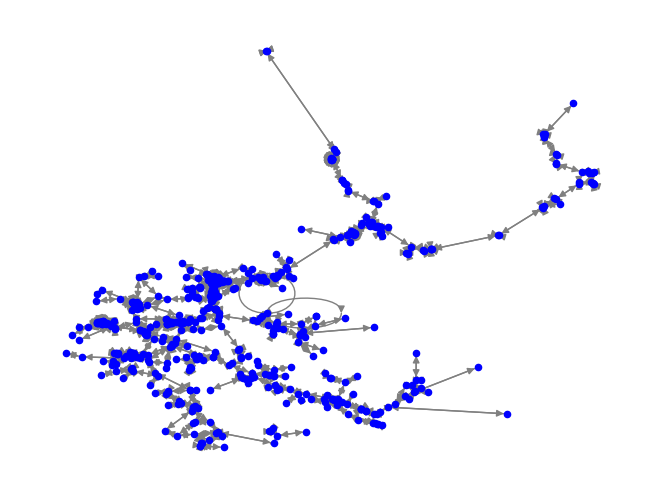

Data saved to 'shortest_paths_feasibility.csv'.


In [41]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import requests
import numpy as np

# Google API settings (replace with your API key)
ELEVATION_API_KEY = 'your_google_maps_elevation_api_key'
DISTANCE_API_KEY = 'your_google_maps_distance_matrix_api_key'
ELEVATION_URL = "https://maps.googleapis.com/maps/api/elevation/json"
DISTANCE_URL = "https://maps.googleapis.com/maps/api/distancematrix/json"

# Function to fetch altitude from Google Elevation API
def get_altitude(lat, lon, api_key=ELEVATION_API_KEY):
    params = {
        'locations': f'{lat},{lon}',
        'key': api_key
    }
    response = requests.get(ELEVATION_URL, params=params)
    if response.status_code == 200:
        results = response.json().get('results')
        if results:
            return results[0]['elevation']
    return None

# Function to fetch distance between two points using Google Distance Matrix API
def get_distance(lat1, lon1, lat2, lon2, api_key=DISTANCE_API_KEY):
    origins = f"{lat1},{lon1}"
    destinations = f"{lat2},{lon2}"
    params = {
        'origins': origins,
        'destinations': destinations,
        'key': api_key
    }
    response = requests.get(DISTANCE_URL, params=params)
    if response.status_code == 200:
        rows = response.json().get('rows')
        if rows:
            elements = rows[0].get('elements')
            if elements and elements[0].get('distance'):
                return elements[0]['distance']['value'] / 1000  # distance in kilometers
    return None

# Step 1: Load the road network from OSMnx for Chamoli, India
place_name = "Chamoli district, India"
G = ox.graph_from_place(place_name, network_type='drive')

# Step 2: Load your CSV file containing latitude and longitude
csv_file = '/content/dataterrain.csv'  # Change this to your actual CSV file path
df = pd.read_csv(csv_file)

# Step 3: Fetch altitude for each coordinate in the CSV
node_altitudes = {}

# Loop through the CSV to get the latitude and longitude, then fetch altitudes
for _, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']  # Adjust if your columns have different names
    nearest_node = ox.distance.nearest_nodes(G, X=lon, Y=lat)  # Find the nearest node in the OSMnx graph
    altitude = get_altitude(lat, lon)  # Fetch altitude from API
    if altitude is not None:
        node_altitudes[nearest_node] = altitude
    else:
        node_altitudes[nearest_node] = 0  # In case the API fails, set altitude to 0

# Step 4: Calculate slope for each edge and add it as edge weight
for u, v, data in G.edges(data=True):
    if u in node_altitudes and v in node_altitudes:
        # Altitude difference
        altitude_u = node_altitudes[u]
        altitude_v = node_altitudes[v]
        altitude_diff = abs(altitude_u - altitude_v)

        # Get coordinates for the two nodes
        lat_u, lon_u = G.nodes[u]['y'], G.nodes[u]['x']
        lat_v, lon_v = G.nodes[v]['y'], G.nodes[v]['x']

        # Fetch the distance between the two coordinates
        distance = get_distance(lat_u, lon_u, lat_v, lon_v)

        # Calculate slope (altitude difference / distance)
        if distance and distance > 0:
            slope = altitude_diff / distance
            data['weight'] = slope
            data['slope'] = slope  # Keep slope in edge data
        else:
            data['weight'] = 0  # Set weight to 0 if distance is invalid
            data['slope'] = 0  # Set slope to 0 if distance is invalid

# Step 5: Floyd-Warshall algorithm for shortest paths based on slope
fw_distances = dict(nx.floyd_warshall(G, weight='weight'))

pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes()}
nx.draw(G, pos, with_labels=False, node_size=20, node_color='blue', edge_color='gray')
plt.show()

# Prepare the data for CSV
csv_data = []
for source, target_distances in fw_distances.items():
    for target, distance in target_distances.items():
        # Determine feasibility
        feasibility = 'Feasible' if distance < 20 else 'Not Feasible'

        # Append to the CSV data list
        csv_data.append([source, target, distance, feasibility])

# Convert to DataFrame and save to CSV
columns = ['Source Node', 'Target Node', 'Distance (km)', 'Feasibility']
df_output = pd.DataFrame(csv_data, columns=columns)
df_output.to_csv('/content/shortest_paths_feasibility.csv', index=False)

print("Data saved to 'shortest_paths_feasibility.csv'.")
